In [1]:
# from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

# wandb_run_id = init_wandb(run_name="price_match_simulation")
# print(f"Run ID {wandb_run_id}")

In [2]:
import pandas as pd
import pickle
import time

from ml_simulation.dataset_split import customer_split
from ml_simulation.util import HiddenPrints
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
from ml_simulation__sales_rep.sample import sample_sales_rep_customers
from ml_simulation__sales_rep.data import get_sales_rep_compute_function
from ml_simulation__sales_rep.widget import show_sales_rep_widget
    
import warnings
warnings.filterwarnings('ignore')

df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

In [3]:
split_result = customer_split(df_quotes)
df_train = split_result['train']
df_sim = split_result['simulation']


SPLIT CUSTOMERS: TRAIN vs SIMULATION: TRAINING SIZE 0.95
Split: 22708 train, 1180 sim customers


In [4]:
TRAIN = False

In [5]:
# Model building
if TRAIN:
    with HiddenPrints():
        X_train = create_features(df_train)
    
    y_train = X_train['converted']
    X_train = X_train.drop(['numero_compte', 'converted'], axis=1)
    feature_names = X_train.columns.tolist()
    
    result = train_xgb(X_train, y_train, "simulation_poc")
    model = result['model']
    feature_names = result['features']
    
    print(f"Model trained: {len(feature_names)} features")
else:
    with open('simulation_poc.pkl', 'rb') as file:
        model_data = pickle.load(file)
        model = model_data['model']
        feature_names = model_data['features']

In [6]:
# Sampling
sample_seed = int(time.time() * 1000) % 10000000
selected_ids = sample_sales_rep_customers(df_sim, random_state=sample_seed)

Non-converted customers: 923
Found 923 candidates • {'neutral': 599, 'price_sensitive': 324}
✓ price_sensitive: CL00340057 (score: -1)
✓ price_sensitive: CL00339578 (score: -1)
✓ neutral: CL00157351 (score: 0)
✓ fallback: CL00319206 (neutral, score: 0)
✓ fallback: CL00345647 (neutral, score: 0)

🎯 Selected 5 customers:
 • CL00340057: price_sensitive (rep: Richard NOEL, score: -1)
 • CL00339578: price_sensitive (rep: Lionel MANERU, score: -1)
 • CL00157351: neutral (rep: VIRGINIE FERREIRA, score: 0)
 • CL00319206: neutral (rep: Julien PAIN, score: 0)
 • CL00345647: neutral (rep: Richard NOEL, score: 0)


Initialized Simulation with 5 sampled IDs.


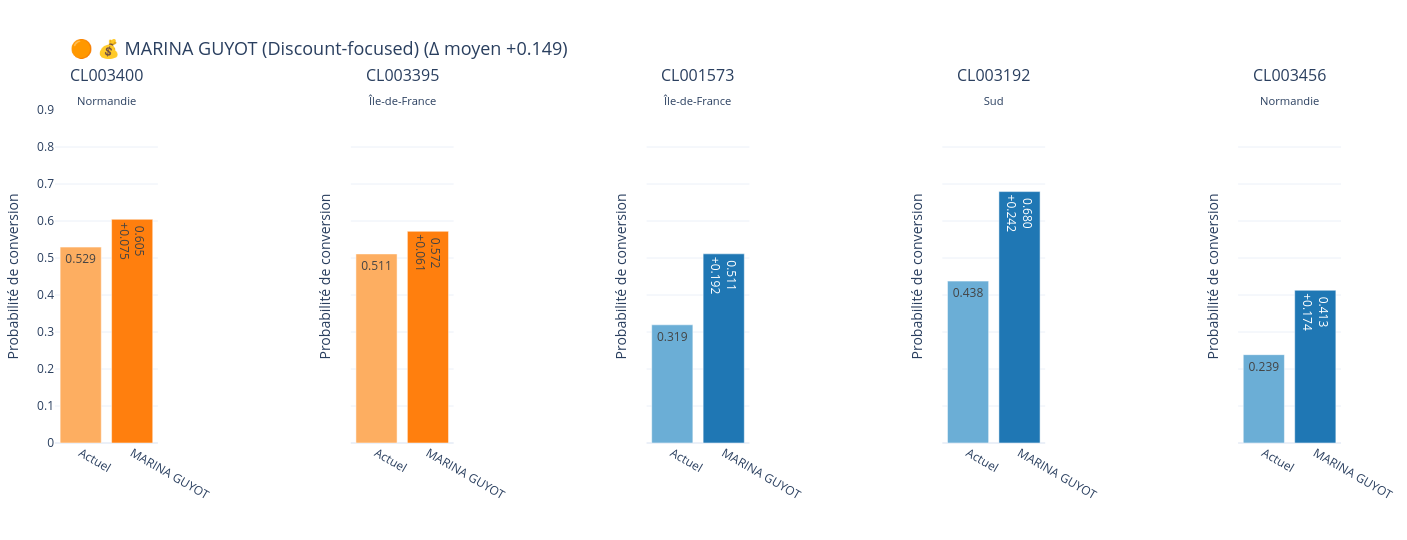

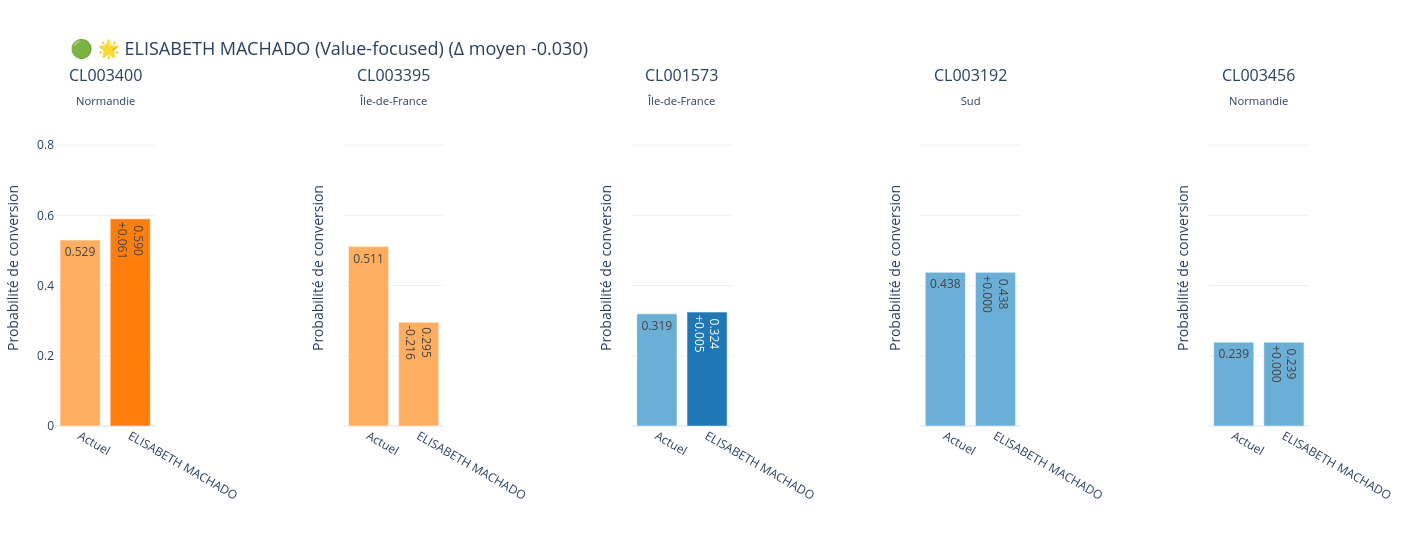

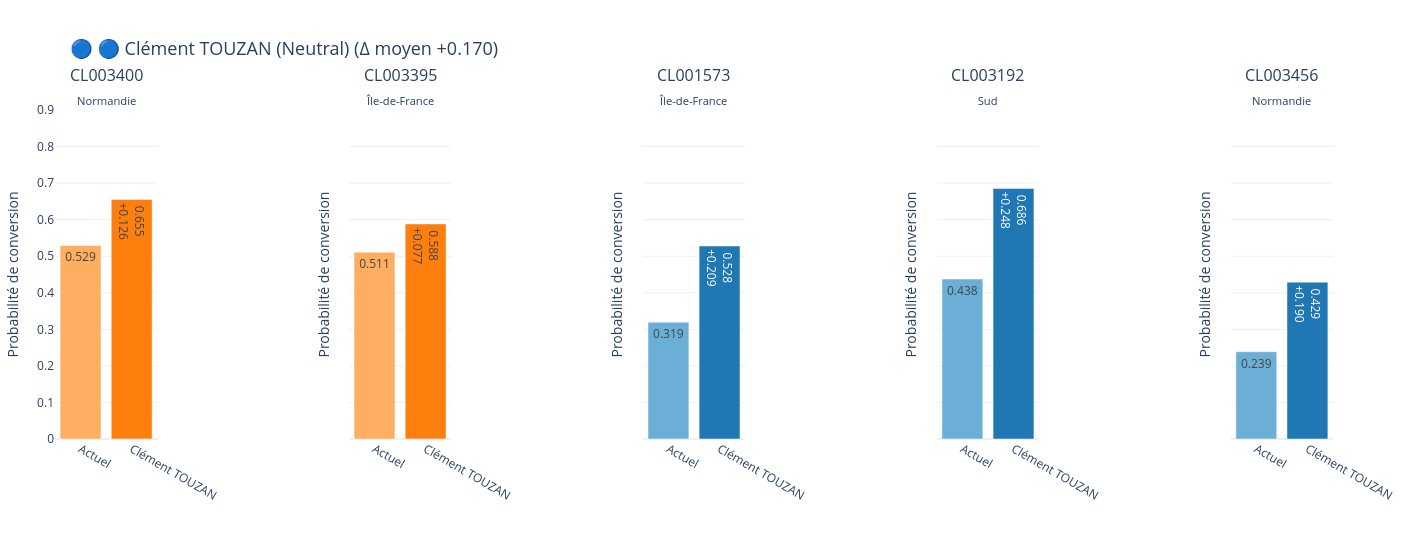

In [7]:
# Simulation
compute = get_sales_rep_compute_function(model, feature_names, df_sim, selected_ids)
show_sales_rep_widget(compute, selected_ids)